사용 디바이스: cuda
데이터셋 로딩 중...
훈련 데이터셋: 8000개
데이터 정규화 적용됨
테스트 데이터셋: 2000개
데이터 정규화 적용됨
모델 생성 완료 - 파라미터 수: 709,066
훈련 시작 - Epochs: 100, LR: 0.004, Device: cuda
Epoch  Train Loss   Test Loss    Best Test   
--------------------------------------------------
0      0.847754     0.498944     0.498944    
5      0.494531     0.370828     0.370828    
10     0.451993     0.322338     0.322338    
15     0.427774     0.307817     0.307817    
20     0.413341     0.280356     0.280356    
25     0.396582     0.273397     0.270385    
30     0.393091     0.264184     0.263365    
35     0.378950     0.262251     0.255207    
40     0.365274     0.255467     0.244109    
45     0.367975     0.247768     0.244109    
50     0.349183     0.239789     0.239789    
55     0.345080     0.240597     0.233646    
60     0.340681     0.237903     0.227009    
65     0.346302     0.222096     0.222096    
70     0.335821     0.232984     0.222096    
75     0.335068     0.246045     0.216025    
80     0.3346

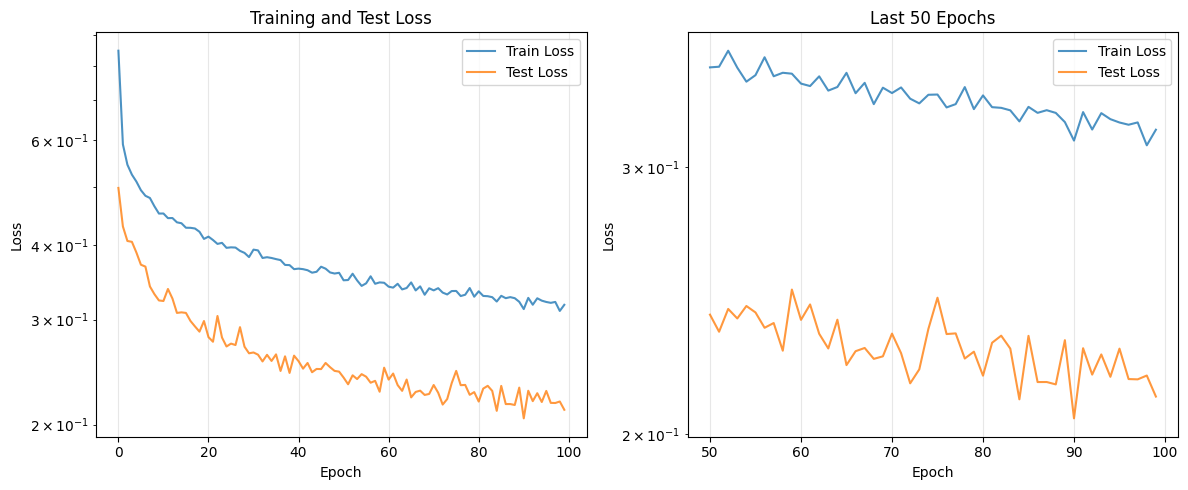


=== 모델 테스트 결과 ===

테스트 1:
방정식: 96.240x^5 + -85.064x^4 + -35.283x^3 + -2.883x^2 + 87.959x + -26.818 = 0
실제 근들:
  근 1: 0.000000 + 0.330089i
  근 2: -0.639122 + -0.647935i
  근 3: 0.639122 + -0.647935i
  근 4: -0.404847 + 0.924824i
  근 5: 0.404847 + 0.924824i
예측 근들:
  근 1: -0.011403 + 0.300751i
  근 2: -0.598926 + -0.545058i
  근 3: 0.640112 + -0.617341i
  근 4: -0.443727 + 0.776051i
  근 5: 0.413316 + 0.120559i
MSE 오차: 0.068469

테스트 2:
방정식: 66.056x^5 + -80.191x^4 + -65.473x^3 + -36.350x^2 + -47.618x + -6.853 = 0
실제 근들:
  근 1: 0.000000 + -0.158890i
  근 2: -0.682937 + 0.058492i
  근 3: 0.682937 + 0.058492i
  근 4: 0.000000 + -0.707753i
  근 5: 0.000000 + 1.963653i
예측 근들:
  근 1: -0.051892 + -0.144391i
  근 2: -0.123166 + -0.467012i
  근 3: -0.411711 + 0.049355i
  근 4: 0.584611 + -0.095137i
  근 5: 0.002516 + 0.936885i
MSE 오차: 0.356207

테스트 3:
방정식: 40.370x^5 + -47.924x^4 + -90.643x^3 + 83.653x^2 + -96.716x + -18.145 = 0
실제 근들:
  근 1: 0.000000 + -0.161493i
  근 2: -0.813692 + 0.427487i
  근 3: 0.813692 + 0

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

class PolynomialDataset(Dataset):
    def __init__(self, data_file, train=True, train_ratio=0.8, normalize=True):
        """
        저장된 데이터 파일로부터 Dataset 생성
        
        Args:
            data_file: 데이터 파일 경로 (.json 또는 .pkl)
            train: True면 훈련용, False면 테스트용
            train_ratio: 훈련/테스트 분할 비율
            normalize: 데이터 정규화 여부
        """
        self.data = self.load_data(data_file)
        self.normalize = normalize
        self.coeffs, self.roots = self.prepare_data()
        
        # 정규화 파라미터 저장
        if normalize:
            self.coeff_mean = np.mean(self.coeffs, axis=0)
            self.coeff_std = np.std(self.coeffs, axis=0) + 1e-8  # 0으로 나누기 방지
            self.root_mean = np.mean(self.roots, axis=0)
            self.root_std = np.std(self.roots, axis=0) + 1e-8
            
            # 정규화 적용
            self.coeffs = (self.coeffs - self.coeff_mean) / self.coeff_std
            self.roots = (self.roots - self.root_mean) / self.root_std
        
        # 훈련/테스트 분할
        train_coeffs, test_coeffs, train_roots, test_roots = train_test_split(
            self.coeffs, self.roots, train_size=train_ratio, random_state=42
        )
        
        if train:
            self.coeffs = train_coeffs
            self.roots = train_roots
        else:
            self.coeffs = test_coeffs
            self.roots = test_roots
        
        print(f"{'훈련' if train else '테스트'} 데이터셋: {len(self.coeffs)}개")
        if normalize:
            print(f"데이터 정규화 적용됨")
    
    def load_data(self, filename):
        """데이터 파일 로드"""
        if filename.endswith('.json'):
            with open(filename, 'r', encoding='utf-8') as f:
                return json.load(f)
        elif filename.endswith('.pkl'):
            with open(filename, 'rb') as f:
                return pickle.load(f)
        else:
            raise ValueError("지원하지 않는 파일 형식입니다. (.json 또는 .pkl 사용)")
    
    def prepare_data(self):
        """데이터를 학습용 형태로 변환 - 새로운 형식 지원"""
        coeffs = []
        roots = []
        
        for item in self.data:
            coeffs.append(item['coefficients'])
            
            # 근 데이터 형식 확인 및 변환
            item_roots = item['roots']
            
            # 정렬된 데이터는 [[실수부, 허수부], ...] 형태
            if isinstance(item_roots[0], list):
                # [[실수부, 허수부], ...] 형태를 [실수부1, 허수부1, ...] 형태로 평탄화
                flattened_roots = []
                for root in item_roots:
                    flattened_roots.extend(root)  # [실수부, 허수부]를 추가
                roots.append(flattened_roots)
            else:
                # 이미 [실수부1, 허수부1, ...] 형태
                roots.append(item_roots)
        
        return np.array(coeffs, dtype=np.float32), np.array(roots, dtype=np.float32)
    
    def denormalize_roots(self, normalized_roots):
        """근을 원래 스케일로 되돌리기"""
        if self.normalize and hasattr(self, 'root_mean'):
            return normalized_roots * self.root_std + self.root_mean
        return normalized_roots
    
    def __len__(self):
        return len(self.coeffs)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.coeffs[idx]), torch.FloatTensor(self.roots[idx])

class PolynomialRootNet(nn.Module):
    def __init__(self, input_size=6, output_size=10, hidden_size=512, num_layers=4, dropout=0.3):
        super(PolynomialRootNet, self).__init__()
        
        layers = []
        current_size = input_size
        
        # 첫 번째 층
        layers.extend([
            nn.Linear(current_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(dropout)
        ])
        current_size = hidden_size
        
        # 중간 층들
        for i in range(num_layers - 2):
            next_size = hidden_size // (2 ** (i + 1))
            next_size = max(next_size, 64)  # 최소 64개 뉴런
            
            layers.extend([
                nn.Linear(current_size, next_size),
                nn.ReLU(),
                nn.BatchNorm1d(next_size),
                nn.Dropout(dropout * 0.8)  # 점진적으로 드롭아웃 감소
            ])
            current_size = next_size
        
        # 출력층
        layers.append(nn.Linear(current_size, output_size))
        
        self.network = nn.Sequential(*layers)
        
        # 가중치 초기화
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        return self.network(x)

class PolynomialTrainer:
    def __init__(self, model, train_loader, test_loader, device='cpu'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        
        # 훈련 기록
        self.train_losses = []
        self.test_losses = []
        self.best_test_loss = float('inf')
        self.best_model_state = None
    
    def polynomial_verification_loss(self, pred_roots, coeffs, weight=0.01):
        """
        예측된 근이 실제로 방정식을 만족하는지 확인하는 손실 (간단한 버전)
        """
        # 너무 복잡한 검증 손실이 문제일 수 있으니 간단하게 수정
        return torch.tensor(0.0, device=pred_roots.device)
    
    def train_epoch(self, optimizer, criterion, use_verification=True):
        self.model.train()
        total_loss = 0
        num_batches = 0
        
        for coeffs, roots in self.train_loader:
            coeffs, roots = coeffs.to(self.device), roots.to(self.device)
            
            optimizer.zero_grad()
            
            # 순전파
            pred_roots = self.model(coeffs)
            
            # 손실 계산
            mse_loss = criterion(pred_roots, roots)
            
            if use_verification:
                # 방정식 검증 손실 추가
                verification_loss = self.polynomial_verification_loss(pred_roots, coeffs)
                total_loss_batch = mse_loss + verification_loss
            else:
                total_loss_batch = mse_loss
            
            # 역전파
            total_loss_batch.backward()
            
            # 그래디언트 클리핑 (폭발 방지)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            total_loss += total_loss_batch.item()
            num_batches += 1
        
        return total_loss / num_batches
    
    def test_epoch(self, criterion):
        self.model.eval()
        total_loss = 0
        num_batches = 0
        
        with torch.no_grad():
            for coeffs, roots in self.test_loader:
                coeffs, roots = coeffs.to(self.device), roots.to(self.device)
                
                pred_roots = self.model(coeffs)
                loss = criterion(pred_roots, roots)
                
                total_loss += loss.item()
                num_batches += 1
        
        return total_loss / num_batches
    
    def train(self, epochs=100, lr=0.001, use_scheduler=False, use_verification=True, save_best=True):
        """모델 훈련"""
        print(f"훈련 시작 - Epochs: {epochs}, LR: {lr}, Device: {self.device}")
        
        # 옵티마이저와 손실함수
        optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-4)
        criterion = nn.MSELoss()
        
        # 학습률 스케줄러
        if use_scheduler:
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=10
            )
        
        print(f"{'Epoch':<6} {'Train Loss':<12} {'Test Loss':<12} {'Best Test':<12}")
        print("-" * 50)
        
        for epoch in range(epochs):
            # 훈련
            train_loss = self.train_epoch(optimizer, criterion, use_verification)
            self.train_losses.append(train_loss)
            
            # 테스트
            test_loss = self.test_epoch(criterion)
            self.test_losses.append(test_loss)
            
            # 스케줄러 업데이트
            if use_scheduler:
                old_lr = optimizer.param_groups[0]['lr']
                scheduler.step(test_loss)
                new_lr = optimizer.param_groups[0]['lr']
                if old_lr != new_lr:
                    print(f"학습률 감소: {old_lr:.6f} -> {new_lr:.6f}")
            
            # 최고 모델 저장
            if save_best and test_loss < self.best_test_loss:
                self.best_test_loss = test_loss
                self.best_model_state = self.model.state_dict().copy()
            
            # 진행 상황 출력
            if epoch % 5 == 0 or epoch == epochs - 1:
                print(f"{epoch:<6} {train_loss:<12.6f} {test_loss:<12.6f} {self.best_test_loss:<12.6f}")
        
        # 최고 모델 로드
        if save_best and self.best_model_state:
            self.model.load_state_dict(self.best_model_state)
            print(f"\n최고 성능 모델 로드 완료 (Test Loss: {self.best_test_loss:.6f})")
    
    def plot_training_curve(self):
        """훈련 곡선 시각화"""
        plt.figure(figsize=(12, 5))
        
        # 손실 곡선
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss', alpha=0.8)
        plt.plot(self.test_losses, label='Test Loss', alpha=0.8)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Test Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.yscale('log')
        
        # 최근 50 에포크 확대
        plt.subplot(1, 2, 2)
        start_idx = max(0, len(self.train_losses) - 50)
        plt.plot(range(start_idx, len(self.train_losses)), 
                self.train_losses[start_idx:], label='Train Loss', alpha=0.8)
        plt.plot(range(start_idx, len(self.test_losses)), 
                self.test_losses[start_idx:], label='Test Loss', alpha=0.8)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Last 50 Epochs')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.yscale('log')
        
        plt.tight_layout()
        plt.show()
    
    def save_model(self, filepath_base, save_formats=['pth', 'pt', 'pkl']):
        """
        모델을 다양한 형식으로 저장
        
        Args:
            filepath_base: 기본 파일 경로 (확장자 제외)
            save_formats: 저장할 형식들 ['pth', 'pt', 'pkl', 'onnx', 'jit']
        """
        model_data = {
            'model_state_dict': self.model.state_dict(),
            'model_architecture': {
                'input_size': 6,
                'output_size': 10,
                'hidden_size': self.model.network[0].out_features,
                'num_layers': len([m for m in self.model.modules() if isinstance(m, nn.Linear)])
            },
            'train_losses': self.train_losses,
            'test_losses': self.test_losses,
            'best_test_loss': self.best_test_loss,
            'model_class': 'PolynomialRootNet'
        }
        
        for fmt in save_formats:
            if fmt == 'pth':
                # PyTorch 기본 형식 (.pth)
                filepath = f"{filepath_base}.pth"
                torch.save(model_data, filepath)
                print(f"PyTorch 모델 저장: {filepath}")
                
            elif fmt == 'pt':
                # PyTorch 압축 형식 (.pt)
                filepath = f"{filepath_base}.pt"
                torch.save(model_data, filepath)
                print(f"PyTorch 압축 모델 저장: {filepath}")
                
            elif fmt == 'pkl':
                # Pickle 형식 (.pkl) - Python 호환성
                import pickle
                filepath = f"{filepath_base}.pkl"
                with open(filepath, 'wb') as f:
                    pickle.dump(model_data, f)
                print(f"Pickle 모델 저장: {filepath}")
                
            elif fmt == 'onnx':
                # ONNX 형식 (.onnx) - 다른 프레임워크와 호환
                try:
                    filepath = f"{filepath_base}.onnx"
                    dummy_input = torch.randn(1, 6)
                    torch.onnx.export(
                        self.model, 
                        dummy_input, 
                        filepath,
                        export_params=True,
                        opset_version=11,
                        do_constant_folding=True,
                        input_names=['coefficients'],
                        output_names=['roots'],
                        dynamic_axes={
                            'coefficients': {0: 'batch_size'},
                            'roots': {0: 'batch_size'}
                        }
                    )
                    print(f"ONNX 모델 저장: {filepath}")
                except Exception as e:
                    print(f"ONNX 저장 실패: {e}")
                    
            elif fmt == 'jit':
                # TorchScript 형식 (.jit) - 배포용
                try:
                    filepath = f"{filepath_base}.jit"
                    traced_model = torch.jit.trace(self.model, torch.randn(1, 6))
                    traced_model.save(filepath)
                    print(f"TorchScript 모델 저장: {filepath}")
                except Exception as e:
                    print(f"TorchScript 저장 실패: {e}")
                    
            elif fmt == 'json':
                # 모델 정보만 JSON으로 저장 (가중치 제외)
                import json
                filepath = f"{filepath_base}_info.json"
                info_data = {
                    'model_architecture': model_data['model_architecture'],
                    'train_losses': model_data['train_losses'],
                    'test_losses': model_data['test_losses'],
                    'best_test_loss': model_data['best_test_loss'],
                    'model_class': model_data['model_class']
                }
                with open(filepath, 'w', encoding='utf-8') as f:
                    json.dump(info_data, f, indent=2, ensure_ascii=False)
                print(f"모델 정보 JSON 저장: {filepath}")
    
    def load_model(self, filepath):
        """저장된 모델 로드"""
        if filepath.endswith('.pth') or filepath.endswith('.pt'):
            checkpoint = torch.load(filepath, map_location=self.device)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.train_losses = checkpoint.get('train_losses', [])
            self.test_losses = checkpoint.get('test_losses', [])
            self.best_test_loss = checkpoint.get('best_test_loss', float('inf'))
            
        elif filepath.endswith('.pkl'):
            import pickle
            with open(filepath, 'rb') as f:
                checkpoint = pickle.load(f)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.train_losses = checkpoint.get('train_losses', [])
            self.test_losses = checkpoint.get('test_losses', [])
            self.best_test_loss = checkpoint.get('best_test_loss', float('inf'))
            
        elif filepath.endswith('.jit'):
            # TorchScript 모델 로드 (별도 처리 필요)
            loaded_model = torch.jit.load(filepath)
            return loaded_model
            
        else:
            raise ValueError(f"지원하지 않는 파일 형식: {filepath}")
        
        print(f"모델 로드 완료: {filepath}")
        return self.model

def test_model(model, test_loader, test_dataset, device, num_examples=3):
    """모델 테스트 및 결과 출력 (정규화 고려) - 수정된 형식 반영"""
    model.eval()
    
    print("\n=== 모델 테스트 결과 ===")
    
    with torch.no_grad():
        for i, (coeffs, true_roots) in enumerate(test_loader):
            if i >= num_examples:
                break
            
            coeffs, true_roots = coeffs.to(device), true_roots.to(device)
            pred_roots = model(coeffs)
            
            # 첫 번째 샘플만 출력
            if coeffs.shape[0] > 0:
                # 정규화된 데이터를 원래 스케일로 복원
                if hasattr(test_dataset, 'denormalize_roots'):
                    true_vals = test_dataset.denormalize_roots(true_roots[0].cpu().numpy())
                    pred_vals = test_dataset.denormalize_roots(pred_roots[0].cpu().numpy())
                else:
                    true_vals = true_roots[0].cpu().numpy()
                    pred_vals = pred_roots[0].cpu().numpy()
                
                # 계수도 복원 (정규화가 적용된 경우)
                if hasattr(test_dataset, 'coeff_mean'):
                    coeff_vals = coeffs[0].cpu().numpy() * test_dataset.coeff_std + test_dataset.coeff_mean
                else:
                    coeff_vals = coeffs[0].cpu().numpy()
                
                print(f"\n테스트 {i+1}:")
                print(f"방정식: {coeff_vals[0]:.3f}x^5 + {coeff_vals[1]:.3f}x^4 + {coeff_vals[2]:.3f}x^3 + {coeff_vals[3]:.3f}x^2 + {coeff_vals[4]:.3f}x + {coeff_vals[5]:.3f} = 0")
                
                print("실제 근들:")
                for j in range(5):
                    # 평탄화된 형식에서 읽기: [실수부1, 허수부1, 실수부2, 허수부2, ...]
                    true_real = true_vals[j*2]      # 실수부
                    true_imag = true_vals[j*2 + 1]  # 허수부
                    if abs(true_imag) < 1e-6:
                        print(f"  근 {j+1}: {true_real:.6f}")
                    else:
                        print(f"  근 {j+1}: {true_real:.6f} + {true_imag:.6f}i")
                
                print("예측 근들:")
                for j in range(5):
                    # 평탄화된 형식에서 읽기: [실수부1, 허수부1, 실수부2, 허수부2, ...]
                    pred_real = pred_vals[j*2]      # 실수부
                    pred_imag = pred_vals[j*2 + 1]  # 허수부
                    if abs(pred_imag) < 1e-6:
                        print(f"  근 {j+1}: {pred_real:.6f}")
                    else:
                        print(f"  근 {j+1}: {pred_real:.6f} + {pred_imag:.6f}i")
                
                # 오차 계산
                mse_error = np.mean((true_vals - pred_vals)**2)
                print(f"MSE 오차: {mse_error:.6f}")

def main():
    # 설정
    data_file = "polynomial_dataset_sorted.json"  # 정렬된 데이터 파일
    batch_size = 32
    epochs = 100
    learning_rate = 0.004
    
    # GPU 사용 가능하면 사용
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"사용 디바이스: {device}")
    
    # 데이터 파일 확인
    if not os.path.exists(data_file):
        print(f"데이터 파일을 찾을 수 없습니다: {data_file}")
        print("먼저 데이터 정렬 스크립트를 실행해주세요!")
        return
    
    # 데이터셋 생성 (정규화 적용)
    print("데이터셋 로딩 중...")
    train_dataset = PolynomialDataset(data_file, train=True, normalize=True)
    test_dataset = PolynomialDataset(data_file, train=False, normalize=True)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # 모델 생성
    model = PolynomialRootNet(hidden_size=1024, num_layers=6, dropout=0.3)
    print(f"모델 생성 완료 - 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")
    
    # 트레이너 생성
    trainer = PolynomialTrainer(model, train_loader, test_loader, device)
    
    # 훈련 실행
    trainer.train(epochs=epochs, lr=learning_rate, use_verification=True)
    
    # 결과 시각화
    trainer.plot_training_curve()
    
    # 모델 테스트
    test_model(trainer.model, test_loader, test_dataset, device)
    
    # 모델 저장 (다양한 형식으로)
    trainer.save_model("best_polynomial_model_sorted", save_formats=['pth', 'onnx', 'jit', 'json'])
    
    print("\n훈련 완료!")

if __name__ == "__main__":
    main()